In [1]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('../')))
os.chdir('../')

In [62]:
import pandas as pd
from statistics import mean
import matplotlib.pyplot as plt

### Local Imports

In [3]:
from modules.get_df_for_preprocessing import GetDfForPreprocessing

## Read data

In [4]:
dist_df = pd.read_csv('data/districts_info.csv')
prod_df = pd.read_csv('data/products_info.csv')

In [5]:
dist_df.head()

,district_id,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio,pp_total_raw
0,8815,Illinois,Suburb,"[0, 0.2[","[0, 0.2[","[0.18, 1[","[14000, 16000["
1,2685,NaN,NaN,NaN,NaN,NaN,NaN
2,4921,Utah,Suburb,"[0, 0.2[","[0.2, 0.4[","[0.18, 1[","[6000, 8000["
3,3188,NaN,NaN,NaN,NaN,NaN,NaN
4,2238,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
prod_df.head()

,LP ID,URL,Product Name,Provider/Company Name,Sector(s),Primary Essential Function
0,13117,https://www.splashmath.com,SplashLearn,StudyPad Inc.,PreK-12,LC - Digital Learning Platforms
1,66933,https://abcmouse.com,ABCmouse.com,"Age of Learning, Inc",PreK-12,LC - Digital Learning Platforms
2,50479,https://www.abcya.com,ABCya!,"ABCya.com, LLC",PreK-12,"LC - Sites, Resources & Reference - Games & Si..."
3,92993,http://www.aleks.com/,ALEKS,McGraw-Hill PreK-12,PreK-12; Higher Ed,LC - Digital Learning Platforms
4,73104,https://www.achieve3000.com/,Achieve3000,Achieve3000,PreK-12,LC - Digital Learning Platforms


### Process District data

In [7]:
prep_dist = GetDfForPreprocessing(dist_df)
prep_dist.print_df_info()

Retrieving info from data...
The number of colum(s): 7.
The column(s) is/are : district_id, state, locale, pct_black/hispanic, pct_free/reduced and pp_total_raw
 
The total number of rows: 233 
The number of columns having missing value(s): 6 
The number of rows with missing value(s) in [state]: 57
The number of rows with missing value(s) in [locale]: 57
The number of rows with missing value(s) in [pct_black/hispanic]: 57
The number of rows with missing value(s) in [pct_free/reduced]: 85
The number of rows with missing value(s) in [county_connections_ratio]: 71
The number of rows with missing value(s) in [pp_total_raw]: 115


### Get insight about states

In [8]:
a = list(dist_df['state'].unique())
len(a)

24

In [9]:
dist_df['state'].mode()

0    Connecticut
dtype: object

There are 23 states in the district data frame. The most occuring state is Connecticut

### Drop null values in ['state'] column

In [10]:
dist_st_notna = dist_df[dist_df['state'].notna()].copy()

In [11]:
prep_ = GetDfForPreprocessing(dist_st_notna)
prep_.print_df_info()

Retrieving info from data...
The number of colum(s): 7.
The column(s) is/are : district_id, state, locale, pct_black/hispanic, pct_free/reduced and pp_total_raw
 
The total number of rows: 176 
The number of columns having missing value(s): 3 
The number of rows with missing value(s) in [pct_free/reduced]: 28
The number of rows with missing value(s) in [county_connections_ratio]: 14
The number of rows with missing value(s) in [pp_total_raw]: 58


### Drop clumn with missing values more than 30% of the total rows

In [12]:
prep_.drop_cols_abv_na_trshld(threshold=0.3)


Comparing threshold with fraction of missing values ...

Retrieving columns to be dropped ...

Columns to be dropped : ['pp_total_raw']

The column(s) to be excluded is/are [[]]

Dropping columns with missing values above the threshold ...

Dropping columns completed

Removing dropped columns from memory...

Removal of dropped columns from memory completed


### Fill missing values with the mode of each column

In [13]:
dist_clean_df = prep_.fill_missing(exclude=[])


The colums with missing values to be filled are ['pct_free/reduced', 'county_connections_ratio']

The column(s) to be excluded is/are []

Filling missing values in pct_free/reduced

Filling missing values in county_connections_ratio

Filling missing values comppleted


In [14]:
dist_clean_df.head()

,district_id,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio
0,8815,Illinois,Suburb,"[0, 0.2[","[0, 0.2[","[0.18, 1["
2,4921,Utah,Suburb,"[0, 0.2[","[0.2, 0.4[","[0.18, 1["
5,5987,Wisconsin,Suburb,"[0, 0.2[","[0, 0.2[","[0.18, 1["
6,3710,Utah,Suburb,"[0, 0.2[","[0.4, 0.6[","[0.18, 1["
7,7177,North Carolina,Suburb,"[0.2, 0.4[","[0.2, 0.4[","[0.18, 1["


### Clean District data

In [15]:
def avg(entry):
    return mean([float(i) for i in entry.strip('[').split(',')])

In [16]:
rnge_cols = dist_clean_df.columns[3:]  # retrieve columns with range values

for col in rnge_cols:
    dist_clean_df[col] = dist_clean_df[col].apply(avg) # find the average of the reanges
dist_clean_df.reset_index(drop=True, inplace=True) # reset the index

In [17]:
dist_clean_df.head()

,district_id,state,locale,pct_black/hispanic,pct_free/reduced,county_connections_ratio
0,8815,Illinois,Suburb,0.1,0.1,0.59
1,4921,Utah,Suburb,0.1,0.3,0.59
2,5987,Wisconsin,Suburb,0.1,0.1,0.59
3,3710,Utah,Suburb,0.1,0.5,0.59
4,7177,North Carolina,Suburb,0.3,0.3,0.59


### Extract infor from ['Primary Essential Function'] column

In [18]:
from collections import defaultdict

p_esn_funct = defaultdict(set)
for e in prod_df['Primary Essential Function'].unique():
    try:
        temp = e.split(' - ')
        p_esn_funct[temp[0]].add(temp[1])
    except:
        pass

for key in p_esn_funct.keys():
    prod_df[key] = 0
    for i in range(len(prod_df)):
        try:
            if key in prod_df['Primary Essential Function'][i]:
                prod_df[key][i] = 1
                
        except:
            pass

sectors = set()
for e in prod_df['Sector(s)'].unique():
    try:
        if ';' in e:
            temp = e.split('; ')
            for i in temp:
                sectors.add(i)
        else:
            sectors.add(i)
    except:
        pass

for key in list(sectors):
    prod_df[key] = 0
    for i in range(len(prod_df)):
        try:
            if key in prod_df['Sector(s)'][i]:
                prod_df[key][i] = 1
                
        except:
            pass

prod_df.dropna(inplace=True)

<ipython-input-18-13732b692ef9>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prod_df[key][i] = 1
<ipython-input-18-13732b692ef9>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prod_df[key][i] = 1


### Create A Dictionary with states as keys and DataFrames as values

In [49]:
filters_dict = {}
for st in dist_clean_df['state']:
    flt = dist_clean_df['state'] == st
    filters_dict[st] = flt

In [50]:
State_df = {k:dist_clean_df[filters_dict[k]].copy() for k in filters_dict.keys()}

In [51]:
# Integrate data from engagement with district data
State_df_full ={}                             
for key in State_df.keys():
    df = State_df[key]
    for d_id, idx in zip(df['district_id'].values, df.index):
        temp_df = pd.read_csv('data/engagement_data/'+ str(d_id) +'.csv')
        temp_df['district_id'] = d_id
        temp_df['locale'] = df['locale'][idx]
        temp_df['state'] = key
        temp_df['pct_black/hispanic'] = df['pct_black/hispanic'][idx]
        temp_df['pct_free/reduced'] = df['pct_free/reduced'][idx]
        temp_df['county_connections_ratio'] = df['county_connections_ratio'][idx]
        temp_df.dropna(inplace=True)
        if key in State_df_full.keys():
            State_df_full[key] = pd.concat([temp_df,State_df_full[key]],ignore_index=True)
        else:
            State_df_full[key] = temp_df

In [52]:
# Integrate data from products with district and engagement data
State_df={}
State_df_full_prod = {}
for key in State_df_full.keys():
    State_df_full_prod[key] = State_df_full[key].merge(prod_df,left_on='lp_id',right_on='LP ID')

### Visualize trends in product type usuage by states

<ipython-input-68-95d53525ff95>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(15, 10))


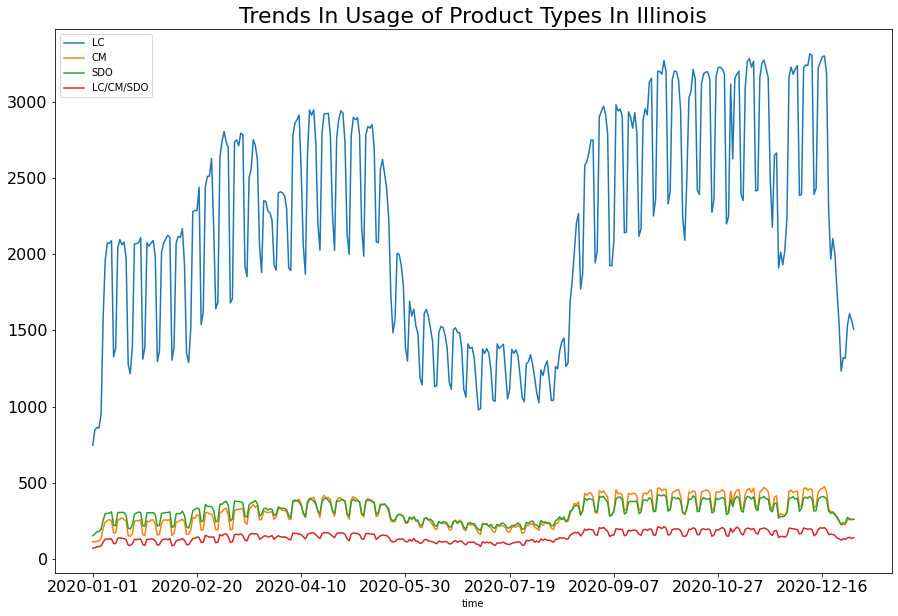

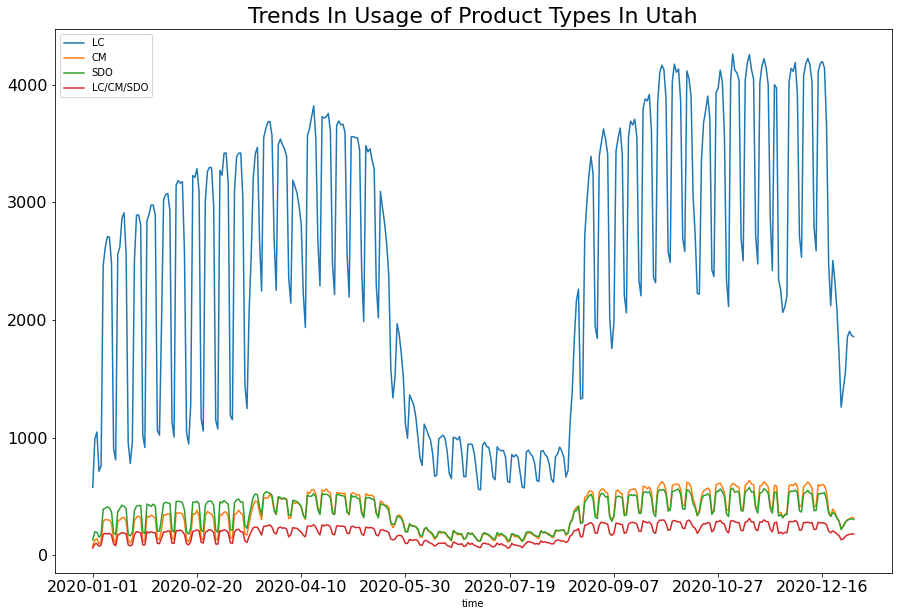

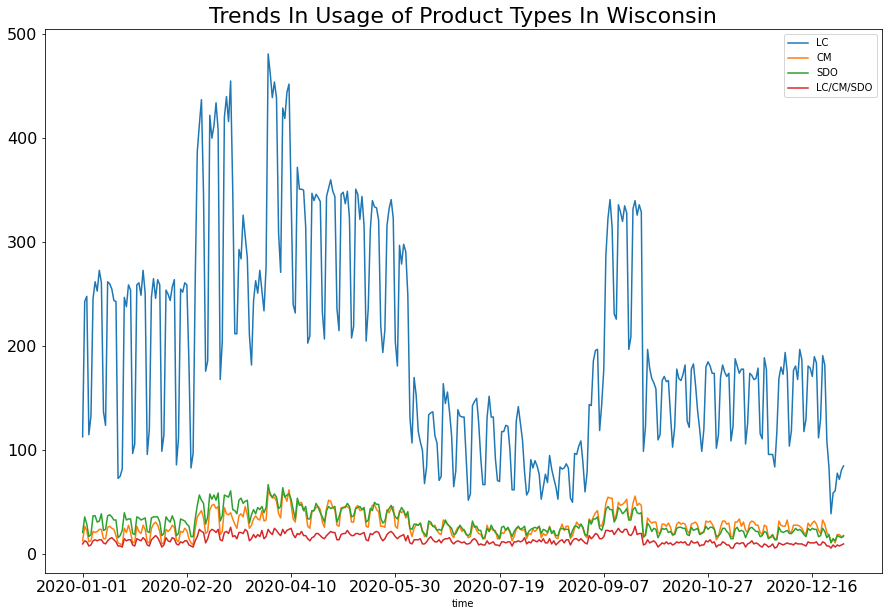

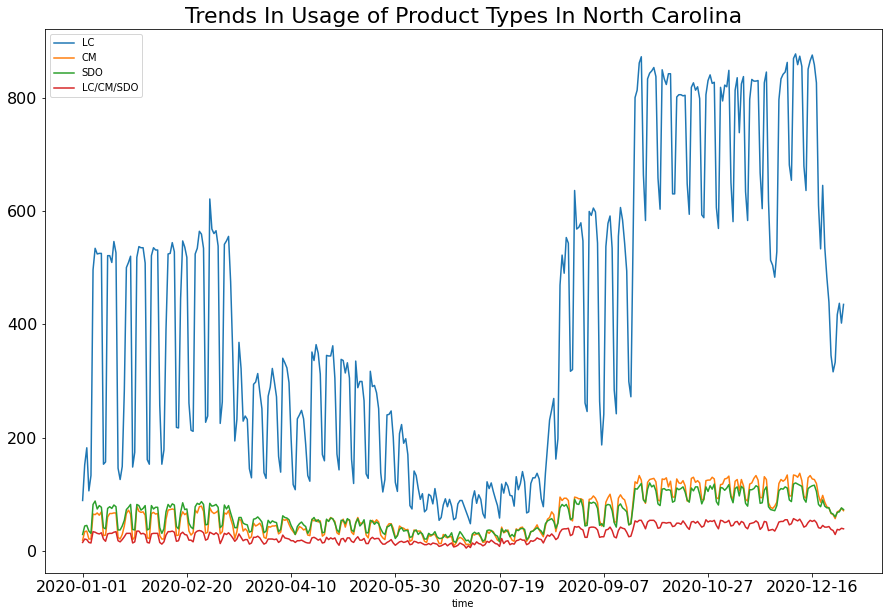

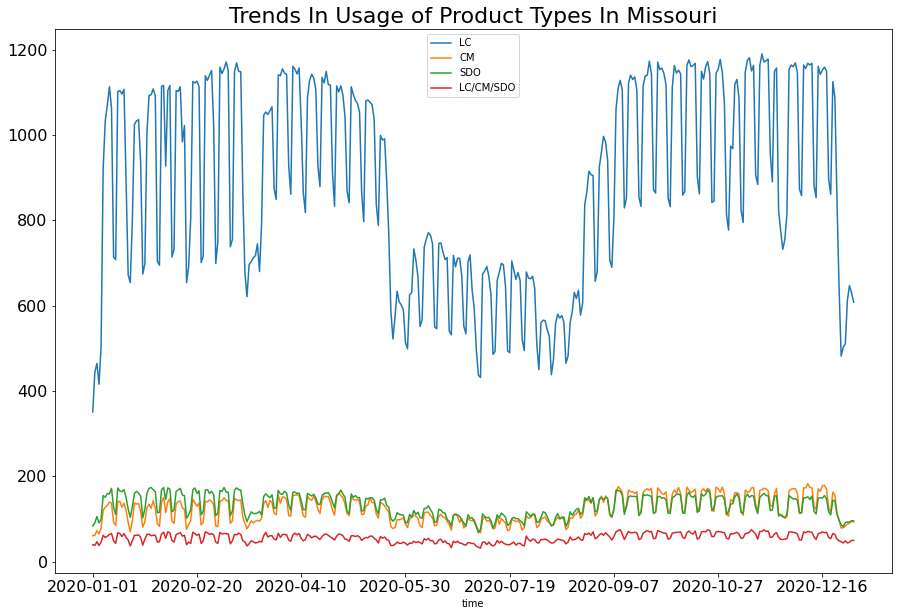

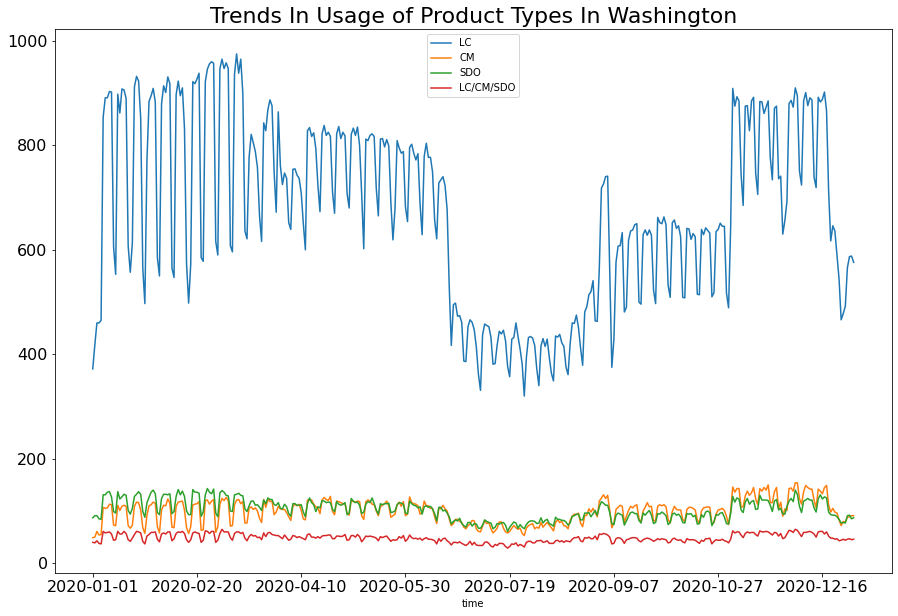

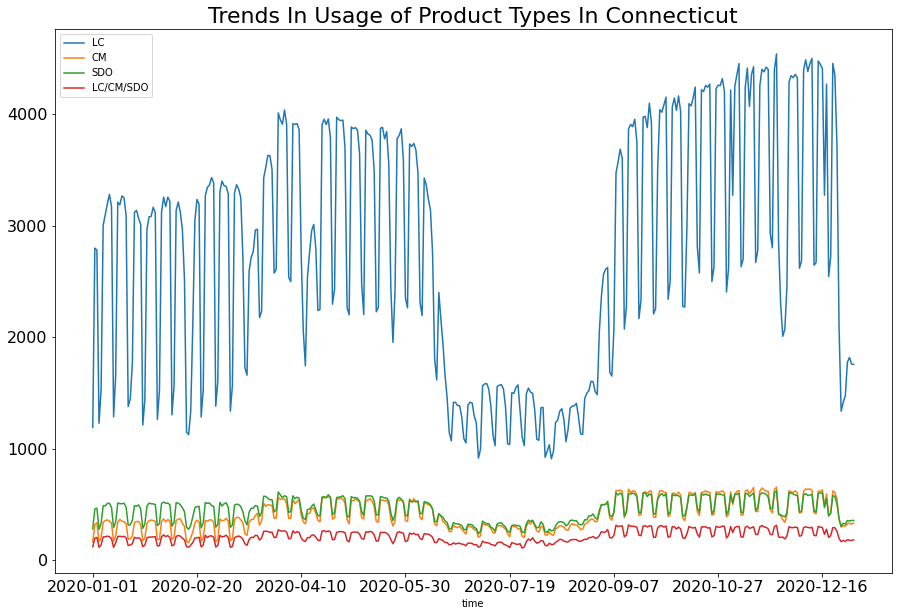

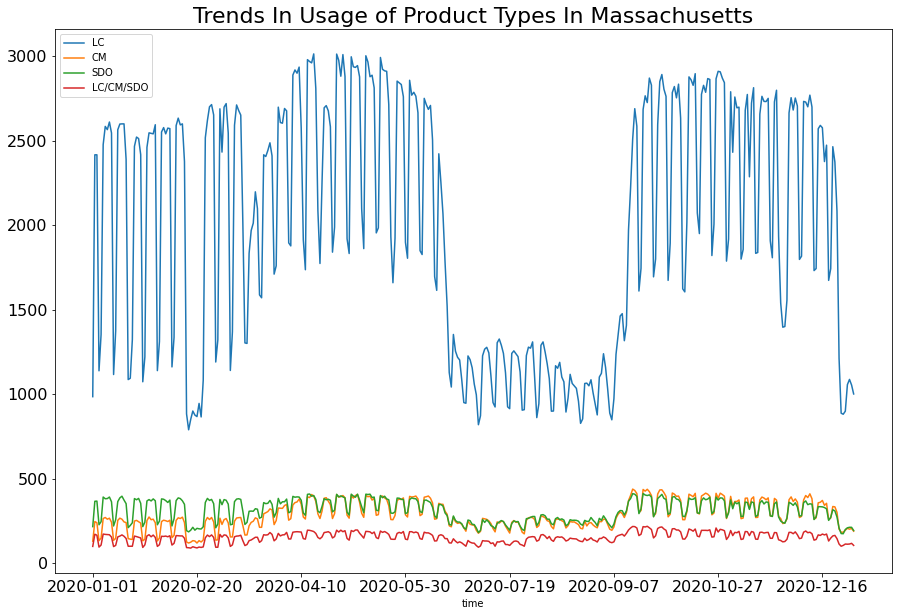

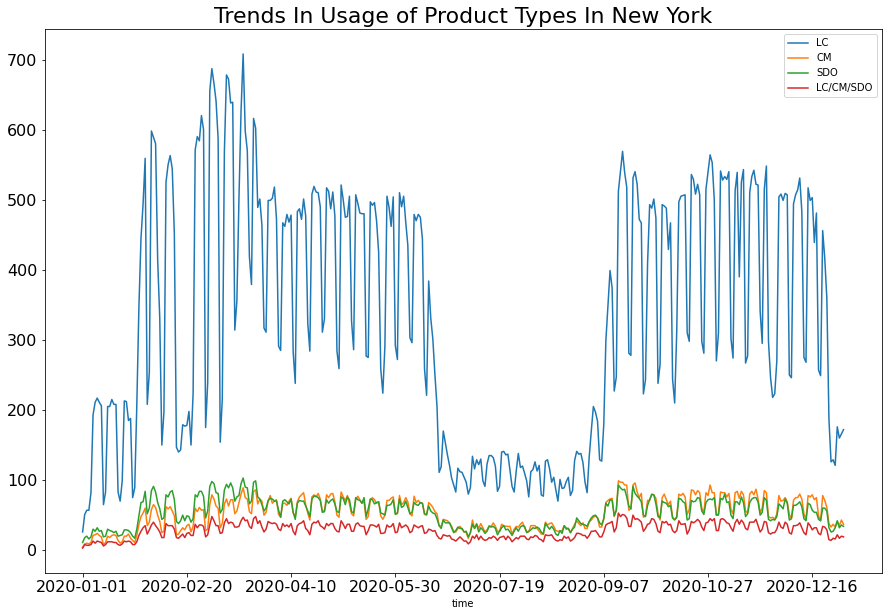

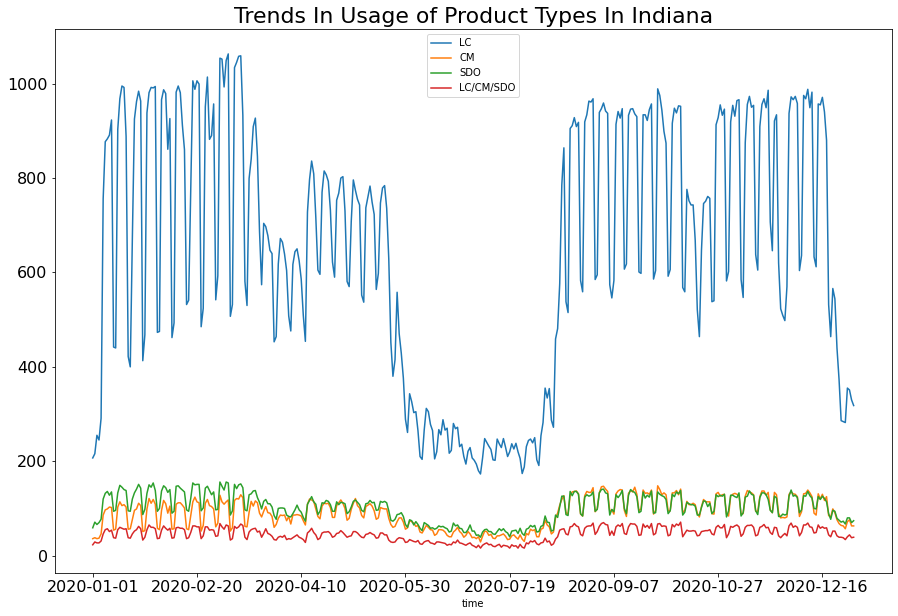

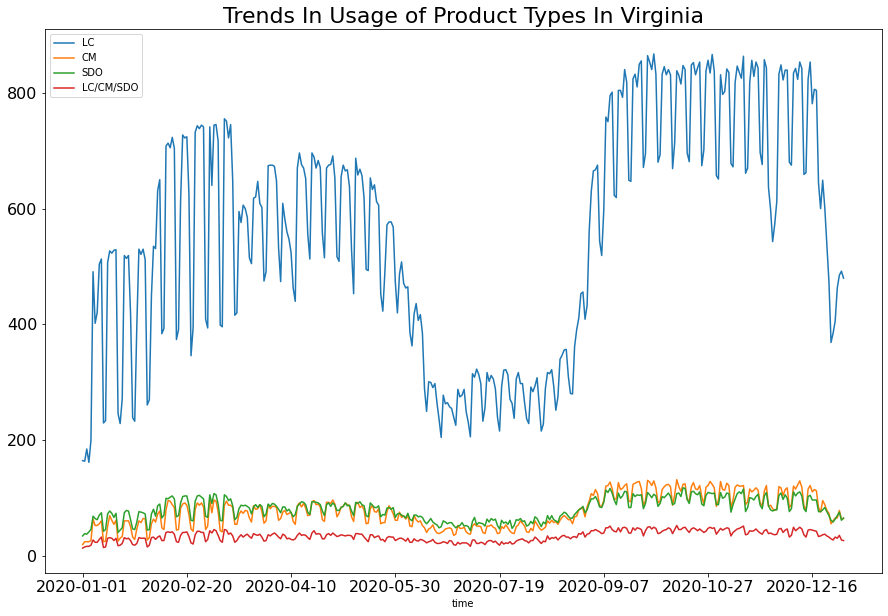

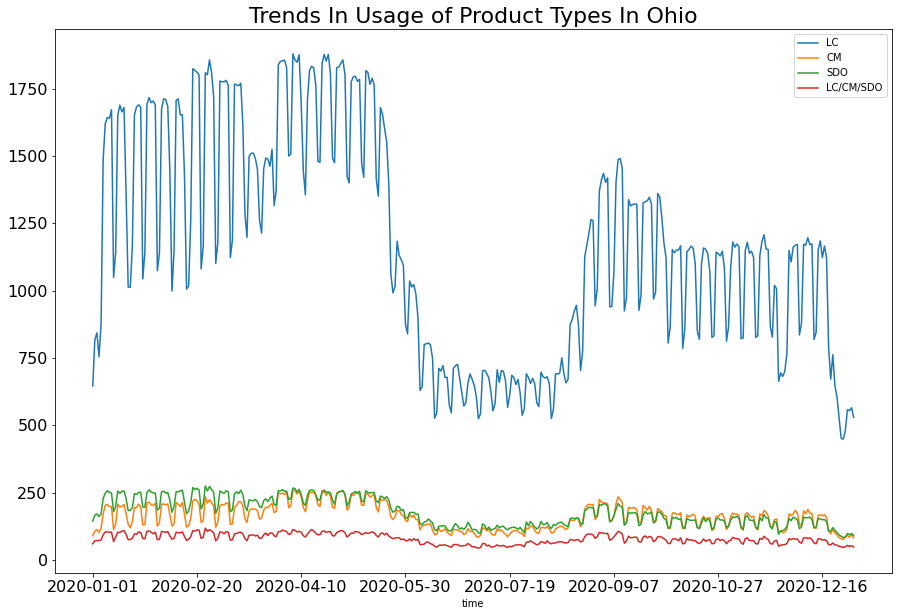

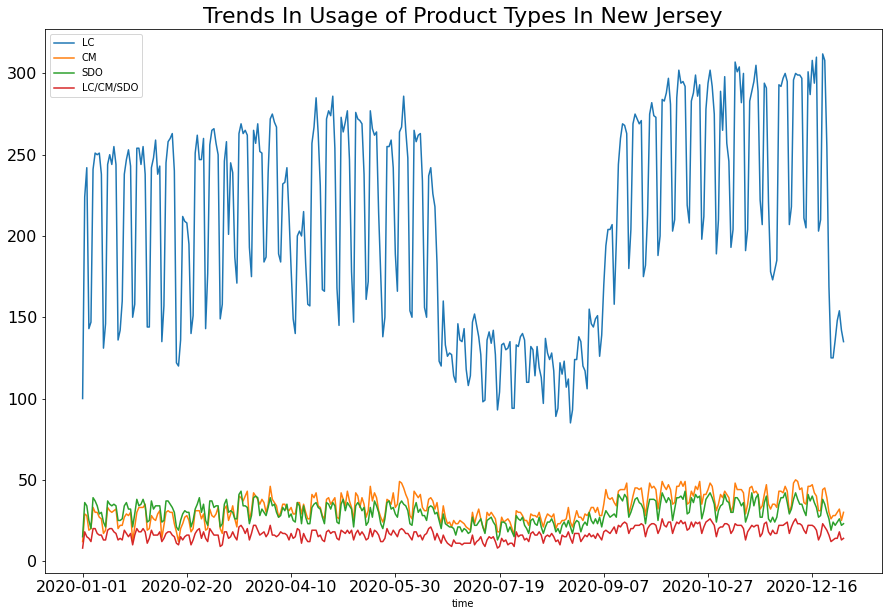

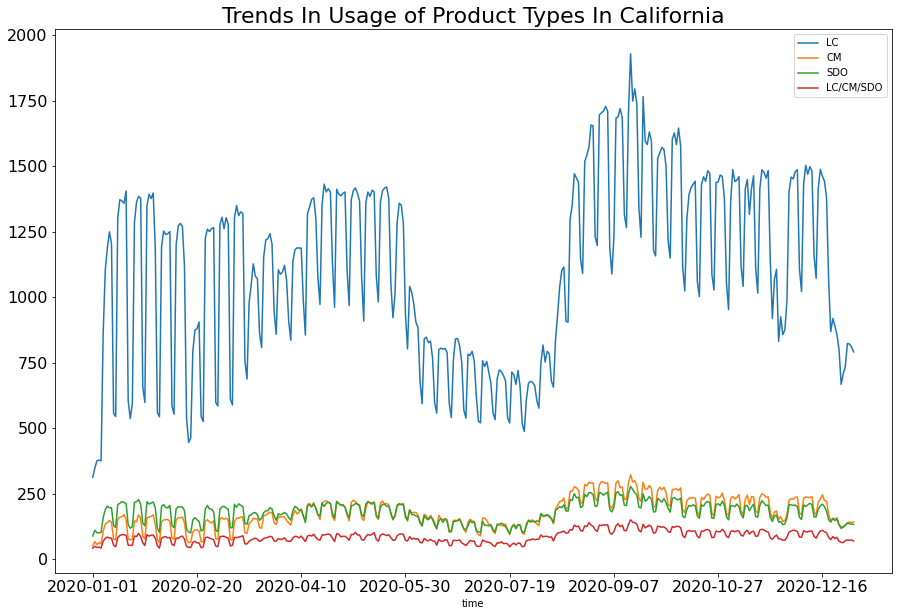

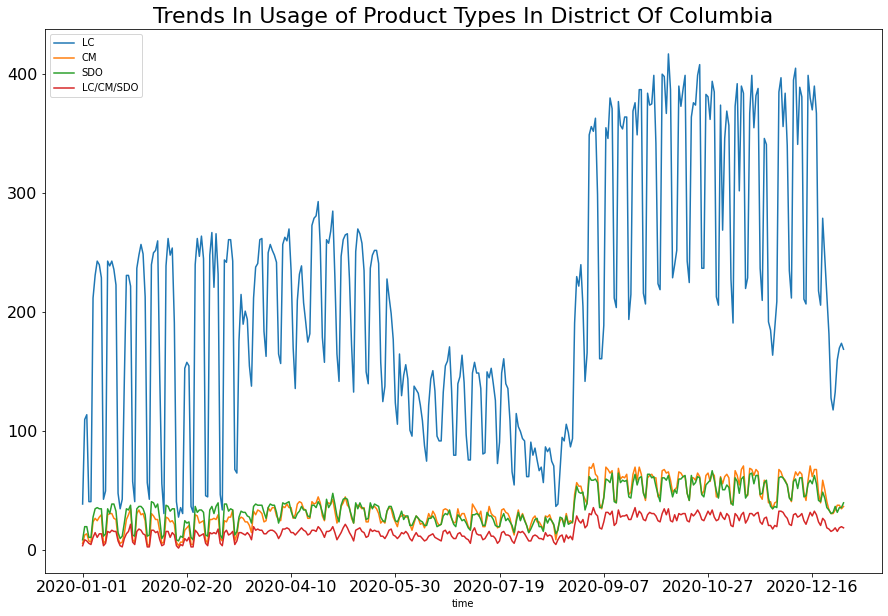

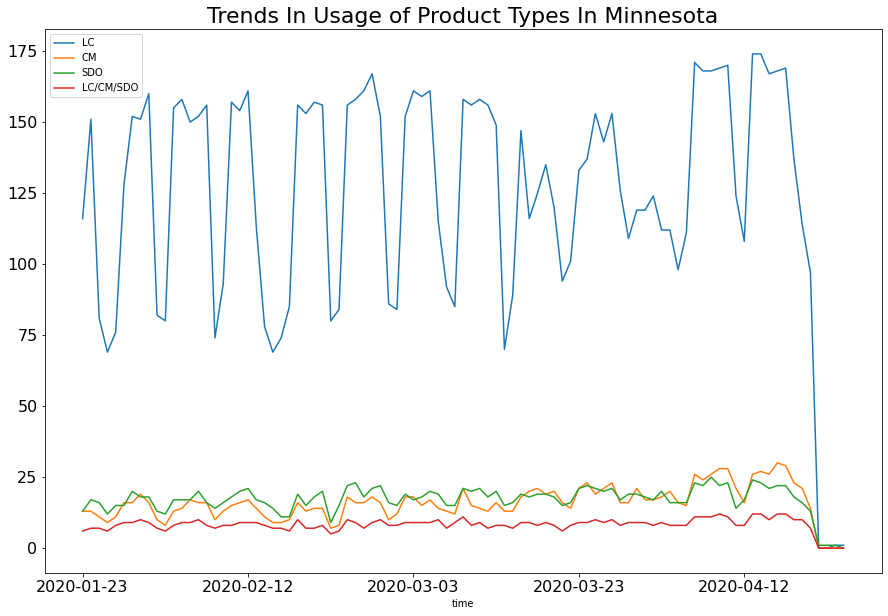

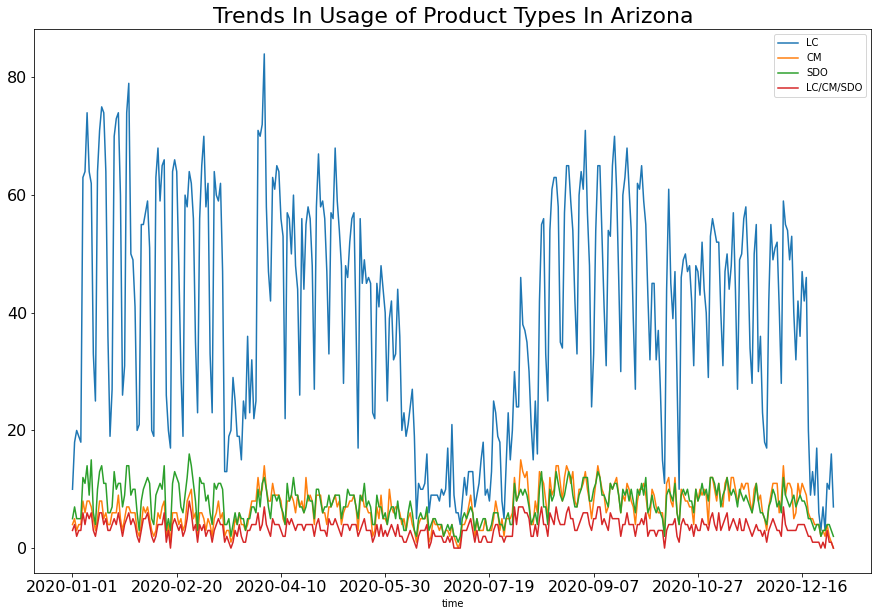

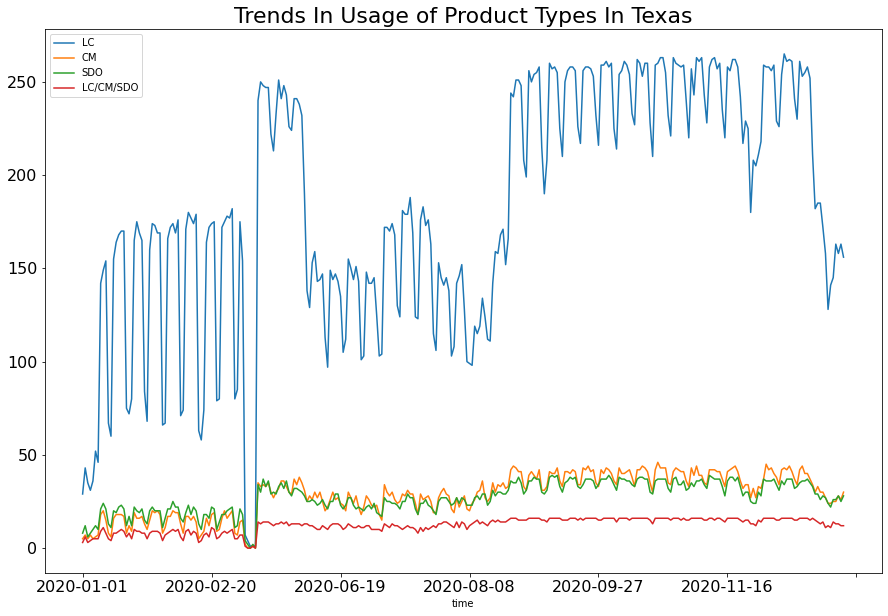

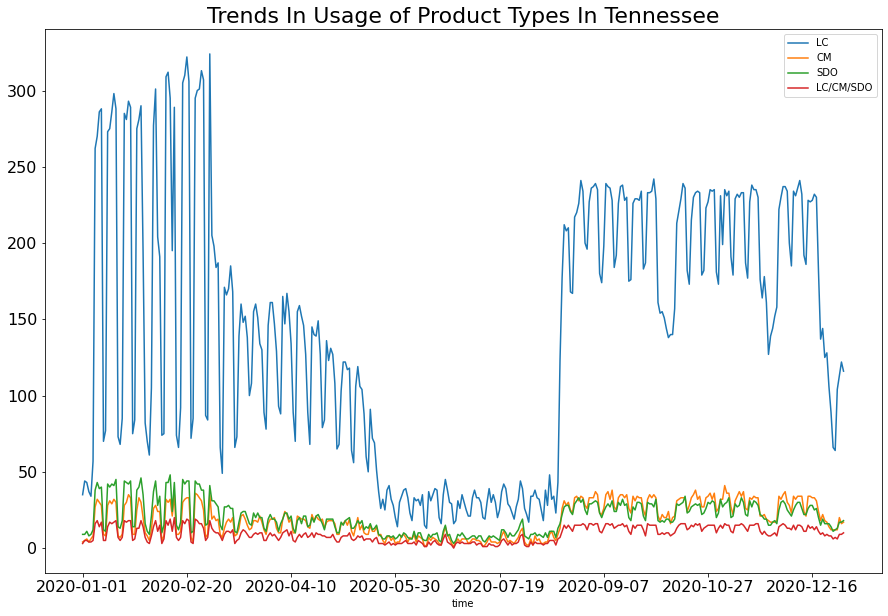

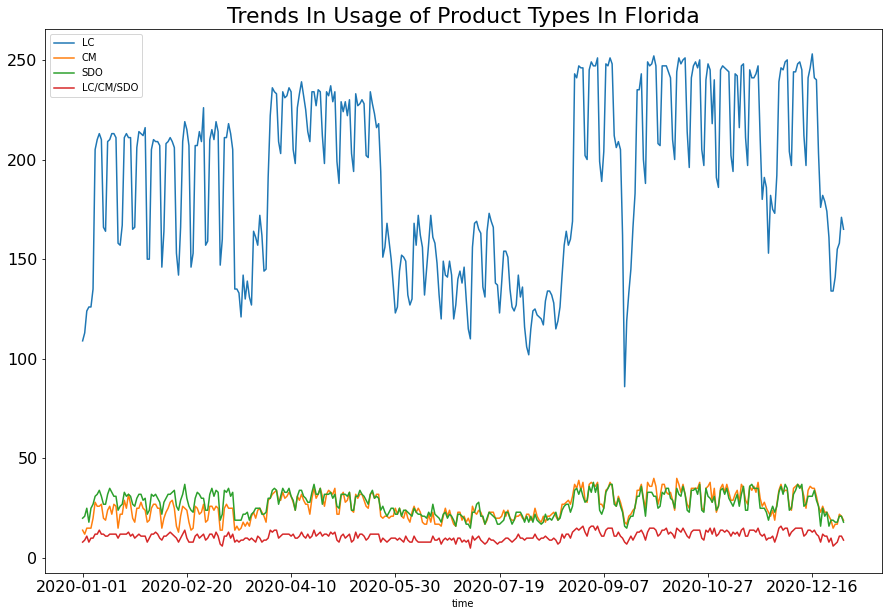

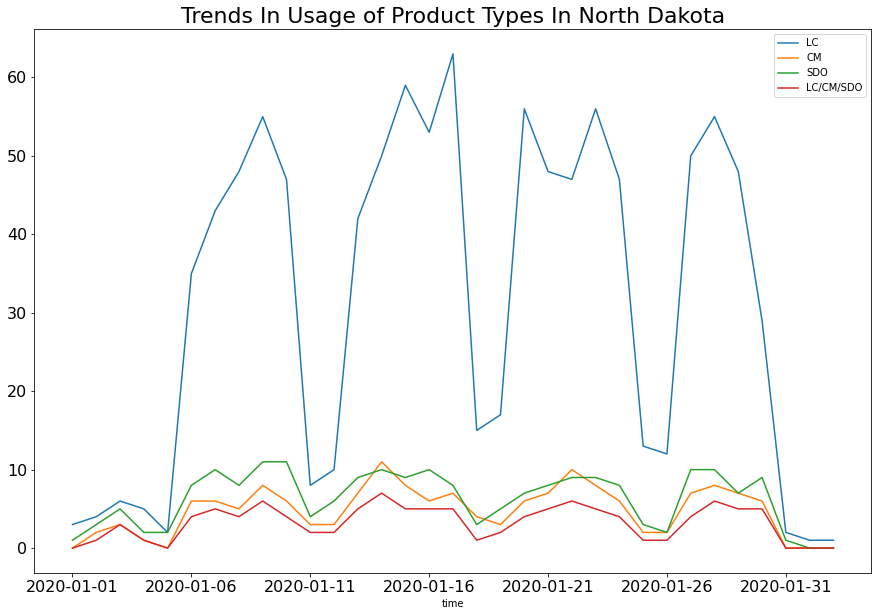

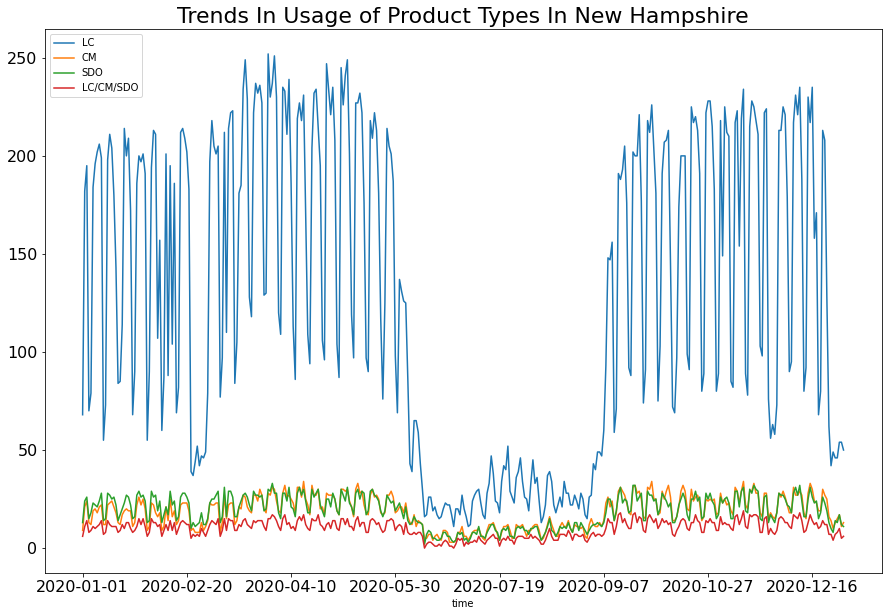

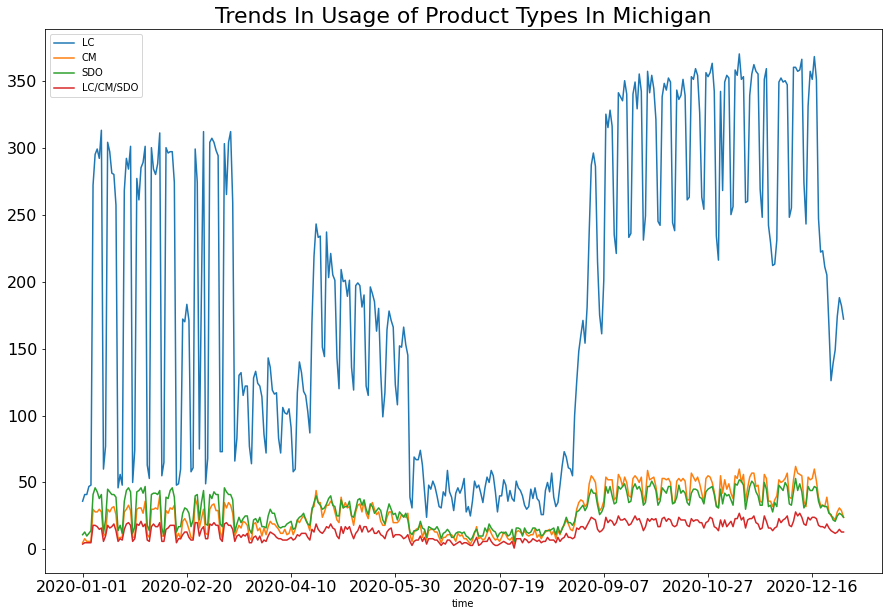

In [68]:
for key in State_df_full_prod.keys():
    fig, ax = plt.subplots(figsize=(15, 10))
    plt.rcParams.update({'axes.titlesize': 'Large'})

    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)
    ax.set_title('Trends In Usage of Product Types In '+ key, fontsize=22)

    State_df_full_prod[key].groupby('time').sum()[['LC', 'CM', 'SDO', 'LC/CM/SDO']].plot(ax=ax)